##1. Imports

In [ ]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf

##2. Loading Data

In [ ]:
# read files
data_dir = '/content/drive/MyDrive/lstm/'

train_df = pd.read_csv(data_dir + "train_set.csv", encoding='latin-1')
test_df = pd.read_csv(data_dir + "test_set.csv")

In [ ]:
train_df.head()

,label,text
0,85389000,pdscpm gb part of panel of chiller
1,85389000,nm p economical extended rot hand parts for c...
2,85389000,lv ma pd trip unit for cvs parts of circuit br...
3,85389000,lv na p trip unit for cvs switch parts of circ...
4,85389000,lv tmd pd trip unit for cvs parts of circuitbr...


In [ ]:
test_df.head()

,text
0,lv tmd pd trip unit for nh parts of circuit br...
1,module tm analog outputs analog output expansi...
2,command group t iii mechanismt p parts forcir...
3,parts of relayelectrical contact issu e f xxup
4,parts for programmable logic controllers dm ...


In [ ]:
# change labels from original labels to its index & remove duplicates
idx2labels = dict(enumerate(train_df['label'].unique()))
labels2idx = {v:k for (k,v) in idx2labels.items()}

train_df = train_df.replace({"label": labels2idx})
train_df = train_df.drop_duplicates().reset_index(drop=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Custom datset class to generate dataset
class CustomDataset:
    def __init__(self, texts, labels):
        """
        :param reviews: this is a numpy array
        :param targets: a vector, numpy array
        """
        self.texts = texts
        self.labels = labels
    def __len__(self):
        # returns length of the dataset
        return len(self.texts)

    def __getitem__(self, item):
        # return review and targets as torch tensor
        text = self.texts[item, :]
        label = self.labels[item]
        return {"text": torch.tensor(text, dtype=torch.long),
                "label": torch.tensor(label, dtype=torch.int)}


##3. Define LSTM Model

In [ ]:
# define model LSTM model
class LSTM(nn.Module):
    def __init__(self, embedding_matrix):
        """
        :param embedding_matrix: numpy array with vectors for all words
        """
        super(LSTM, self).__init__()
        # number of words = number of rows in embedding matrix
        num_words = embedding_matrix.shape[0]
        embed_dim = embedding_matrix.shape[1]
        # define an input embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=num_words,
            embedding_dim=embed_dim
        )
        # embedding matrix is used as weights of
        # the embedding layer
        self.embedding.weight = nn.Parameter(
            torch.tensor(
            embedding_matrix,
            dtype=torch.float32
            )
        )
        # not training the embeddings
        self.embedding.weight.requires_grad = True  
        # hidden size = 128
        self.lstm = nn.LSTM(
            embed_dim,
            128,
            bidirectional=True,
            batch_first=True,
        )
        # input 2*(256) => 128 + 128 for mean and same for max pooling
        self.out = nn.Linear(512, 64)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.out1 = nn.Linear(64, 12)

    def forward(self, x):
        # pass input through defined layer
        x = self.embedding(x)
        # move embedding output to lstm
        x, _ = self.lstm(x)
        # apply mean and max pooling on lstm output
        avg_pool = torch.mean(x, 1)
        max_pool, _ = torch.max(x, 1)

        # 128+128 for each direction = 512
        out = torch.cat((avg_pool, max_pool), 1)
        out = self.out(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.out1(out)
        
        return out

##4. Train and Evaluate

In [ ]:
# define train and evaluate function
def train(data_loader, model, optimizer, device):
    """
    This is the main training function that trains model
    for one epoch.
    """
    # set model to training mode
    model.train()
    
    for data in data_loader:
        # fetching text and label
        texts = data["text"]
        labels = data["label"]
        texts = texts.to(device, dtype=torch.long)
        labels = labels.to(device, dtype=torch.long)
        optimizer.zero_grad()
        predictions = model(texts)
        loss = nn.CrossEntropyLoss()(
            predictions,
            labels
        )
        loss.backward()
        optimizer.step()

def evaluate(data_loader, model, device):
    # store predictions and targets
    final_predictions = []
    final_labels = []
    # put the model in eval mode
    model.eval()

    with torch.no_grad():
        for data in data_loader:
            texts = data["text"]
            labels = data["label"]
            texts = texts.to(device, dtype=torch.long)
            labels = labels.to(device, dtype=torch.long)
            predictions = model(texts)
            predictions = predictions.cpu().numpy().tolist()
            labels = data["label"].cpu().numpy().tolist()
            final_predictions.extend(predictions)
            final_labels.extend(labels)
            
    return final_predictions, final_labels

In [ ]:
# config data 
MAX_LEN = 128
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 32
EPOCHS = 25

In [ ]:
# split the data into train & validation set
x_train, x_valid, y_train, y_valid = train_test_split(train_df.text.values,train_df.label.values, test_size=0.1)

# create a character vocabulory
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(train_df.text.values.tolist())

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_valid)

x_train = tf.keras.preprocessing.sequence.pad_sequences(
x_train, maxlen=MAX_LEN
)
x_val = tf.keras.preprocessing.sequence.pad_sequences(
x_val, maxlen=MAX_LEN
)

train_dataset = CustomDataset(
    texts=x_train,
    labels=y_train
)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=2
)

valid_dataset = CustomDataset(
    texts=x_val,
    labels=y_valid 
)

valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    num_workers=1
)

dim = len(tokenizer.word_index)
embedding_matrix = np.random.randn(dim + 1,dim + 1)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = LSTM(embedding_matrix)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

print("Training Model")
best_accuracy = 0
best_model = None 
# set early stopping counter to zero
early_stopping_counter = 0
# train and validate for all epochs
for epoch in range(EPOCHS):
    train(train_data_loader, model, optimizer, device)
    train_outputs, train_targets = evaluate(
        train_data_loader, model, device 
    )
    train_outputs = np.argmax(train_outputs, axis=1)
    train_accuracy = metrics.accuracy_score(train_targets, train_outputs)

    val_outputs, val_targets = evaluate(
        valid_data_loader, model, device
    )
    val_outputs = np.argmax(val_outputs, axis=1)

    val_accuracy = metrics.accuracy_score(val_targets, val_outputs)
    print(f"Epoch: {epoch},Train Accuracy = {train_accuracy} Val Accuracy = {val_accuracy}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model
print("Best Accuracy: ", best_accuracy)

Training Model
Epoch: 0,Train Accuracy = 0.4790893101426617 Val Accuracy = 0.44991212653778556
Epoch: 1,Train Accuracy = 0.6188196208716045 Val Accuracy = 0.6124780316344464
Epoch: 2,Train Accuracy = 0.6653312487785812 Val Accuracy = 0.655536028119508
Epoch: 3,Train Accuracy = 0.7136994332616767 Val Accuracy = 0.6854130052724078
Epoch: 4,Train Accuracy = 0.746531170607778 Val Accuracy = 0.7152899824253075
Epoch: 5,Train Accuracy = 0.7670510064490913 Val Accuracy = 0.7214411247803163
Epoch: 6,Train Accuracy = 0.7946062145788548 Val Accuracy = 0.7565905096660809
Epoch: 7,Train Accuracy = 0.7981239007230799 Val Accuracy = 0.7574692442882249
Epoch: 8,Train Accuracy = 0.8271448114129373 Val Accuracy = 0.7847100175746925
Epoch: 9,Train Accuracy = 0.8358413132694938 Val Accuracy = 0.7741652021089631
Epoch: 10,Train Accuracy = 0.8556771545827634 Val Accuracy = 0.7961335676625659
Epoch: 11,Train Accuracy = 0.8672073480555013 Val Accuracy = 0.7943760984182777
Epoch: 12,Train Accuracy = 0.8746335

##5. Result Analysis

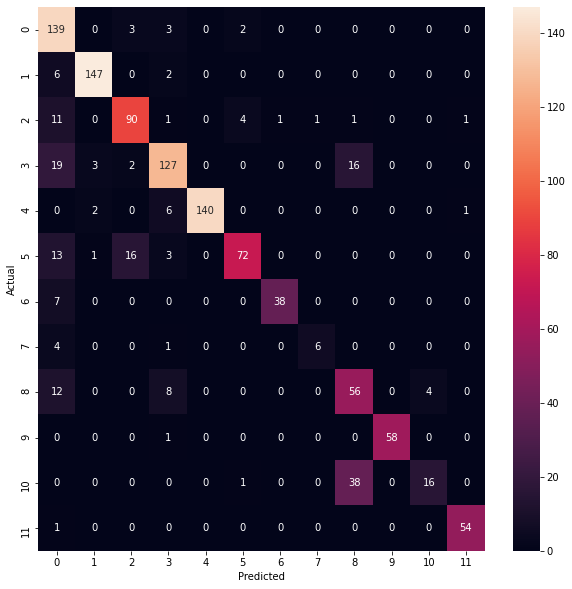

In [ ]:
# generate heatmap to analyze the result
conf_mat = confusion_matrix(val_targets, val_outputs)

ig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

##6. Save & load model and predict on test set

In [ ]:
torch.save(best_model.state_dict(), data_dir + 'models/model.pth')

In [ ]:
model = LSTM(embedding_matrix)
model.load_state_dict(torch.load(data_dir + 'models/model.pth'))
model.eval()

LSTM(
  (embedding): Embedding(30, 30)
  (lstm): LSTM(30, 128, batch_first=True, bidirectional=True)
  (out): Linear(in_features=512, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (out1): Linear(in_features=64, out_features=12, bias=True)
)

In [ ]:
# predict the labels of test data
test_data = test_df.text.values
test_data = tokenizer.texts_to_sequences(test_data)
test_data = tf.keras.preprocessing.sequence.pad_sequences(
test_data, maxlen=MAX_LEN
)
test_data = torch.Tensor(test_data)
test_data = test_data.to(device, dtype=torch.long)
model.to(device)
test_pred = model(test_data)
test_pred = test_pred.cpu().detach().numpy().tolist()

In [ ]:
test_df['label'] = test_pred
test_df = test_df.replace({"label": idx2labels})
test_df.to_csv(data_dir + 'predicted_test_set.csv')
print("Complete!")

Complete!
